# Подержанные автомобили

Датасет содержит информацию о характеристиках и ценах подержанных автомобилей в некоторой стране

## Импорт библиотек, константы

In [ ]:
! pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from catboost import CatBoostRegressor
sns.set_style("darkgrid")

In [ ]:
RANDOM_STATE = 42

In [ ]:
#DATASET_PATH = "https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/cars.csv"

In [ ]:
! gdown 1UoaEIq2U9FrngBes70cyFJh1829EtT0v

Downloading...
From: https://drive.google.com/uc?id=1UoaEIq2U9FrngBes70cyFJh1829EtT0v
To: /content/cars.csv
100% 903k/903k [00:00<00:00, 124MB/s]


In [ ]:
DATASET_PATH = '/content/cars.csv'

## Загрузка и обзор данных

### Загрузка

In [ ]:
# загрузка данных
df = pd.read_csv(DATASET_PATH)
# случайные три записи из датасета
df.sample(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
5676,Honda WR-V i-VTEC VX,2017,675000,25000,Petrol,Individual,Manual,Second Owner,17.5 kmpl,1199 CC,88.7 bhp,110Nm@ 4800rpm,5.0
4096,Mercedes-Benz CLA 200 CGI Sport,2018,2550000,18000,Petrol,Dealer,Automatic,First Owner,15.04 kmpl,1991 CC,183 bhp,300Nm@ 1200-4000rpm,5.0
4433,BMW 5 Series 520d Luxury Line,2016,3200000,40000,Diesel,Individual,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0


### Описание данных

**Целевая переменная**
- `selling_price`: цена продажи, числовая

**Признаки**
- `name` (string): модель автомобиля
- `year` (numeric, int): год выпуска с завода-изготовителя
- `km_driven` (numeric, int): пробег на дату продажи
- `fuel` (categorical: _Diesel_ или _Petrol_, или _CNG_, или _LPG_, или _electric_): тип топлива
- `seller_type` (categorical: _Individual_ или _Dealer_, или _Trustmark Dealer_): продавец
- `transmission` (categorical: _Manual_ или _Automatic_): тип трансмиссии
- `owner` (categorical: _First Owner_ или _Second Owner_, или _Third Owner_, или _Fourth & Above Owner_): какой по счёту хозяин?
- `mileage` (string, по смыслу числовой): пробег, требует предобработки
- `engine` (string, по смыслу числовой): рабочий объем двигателя, требует предобработки
- `max_power` (string, по смыслу числовой): пиковая мощность двигателя, требует предобработки
- `torque` (string, по смыслу числовой, а то и 2): крутящий момент, требует предобработки
- `seats` (numeric, float; по смыслу categorical, int)

### Изучение данных

In [ ]:
df.info() # информация от столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


In [ ]:
(df.isna().agg(['sum', 'mean'])
    .style.set_caption('Количество пропусков')
    .set_table_styles([{'selector': 'caption',
                     'props': [('color', 'black'), ('font-size', '15px')]
                     }]))

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
sum,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,202.000000,202.000000,196.000000,203.000000,202.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028861,0.028861,0.028004,0.029004,0.028861


Пропуски есть в 5 столбцах, позже подумаем как с ними поступить.

In [ ]:
print('Количество уникальных значений в каждой колонке:')
for index in df.columns:
    row = df[index].nunique()
    print(f'Уникальный значений {index}: {row}')

Количество уникальных значений в каждой колонке:
Уникальный значений name: 1924
Уникальный значений year: 29
Уникальный значений selling_price: 637
Уникальный значений km_driven: 827
Уникальный значений fuel: 4
Уникальный значений seller_type: 3
Уникальный значений transmission: 2
Уникальный значений owner: 5
Уникальный значений mileage: 386
Уникальный значений engine: 120
Уникальный значений max_power: 316
Уникальный значений torque: 419
Уникальный значений seats: 9


Посомтрим на распределение машин по типу топлива.

In [ ]:
df['fuel'].value_counts(normalize=True, ascending=False).to_frame().style.background_gradient(
    cmap='Blues').format(precision=3)

,fuel
Diesel,0.542
Petrol,0.446
CNG,0.007
LPG,0.005


Посмотрим какие продавцы у нас представлены

In [ ]:
df['seller_type'].value_counts(normalize=True, ascending=False).to_frame().style.background_gradient(
    cmap='Blues').format(precision=3)

,seller_type
Individual,0.832
Dealer,0.138
Trustmark Dealer,0.029


Больше 80% это частные продавцы  
Посомтрим на распределение по типу коробки

In [ ]:
df['transmission'].value_counts(normalize=True, ascending=False).to_frame()

,transmission
Manual,0.870839
Automatic,0.129161


Посмотрим на распределение целевой переменной.



Среднее значение: 639515.2
Медианное значение: 450000.0
Минимальное значение: 29999
Максимальное значение: 10000000


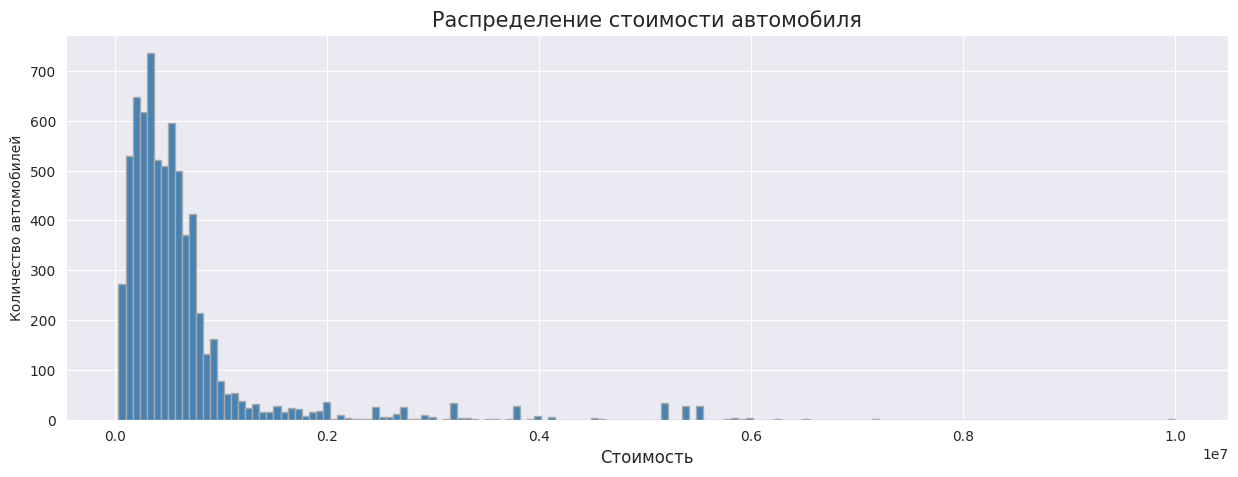

In [ ]:
df['selling_price'].hist(bins=150, color='steelblue',figsize=(15, 5), ec="darkgrey")
print(f"Среднее значение: {df['selling_price'].mean().round(2)}")
print(f"Медианное значение: {df['selling_price'].median().round(2)}")
print(f"Минимальное значение: {df['selling_price'].min().round(2)}")
print(f"Максимальное значение: {df['selling_price'].max().round(2)}")
plt.title('Распределение стоимости автомобиля', fontsize=15)
plt.xlabel('Стоимость', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=10)
plt.show()

Очень сильный разброс цены.    
Распределение скошено вправо. Среднее значение больше медианы, наблюдается длинный хвост.  
Посмотрим на максимальное значение

In [ ]:
df[df['selling_price'] == df['selling_price'].max()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0 kmpl,1969 CC,400 bhp,640Nm@ 1740rpm,4.0


Уберем выбросы (5% машин), посмотрим как изменится график

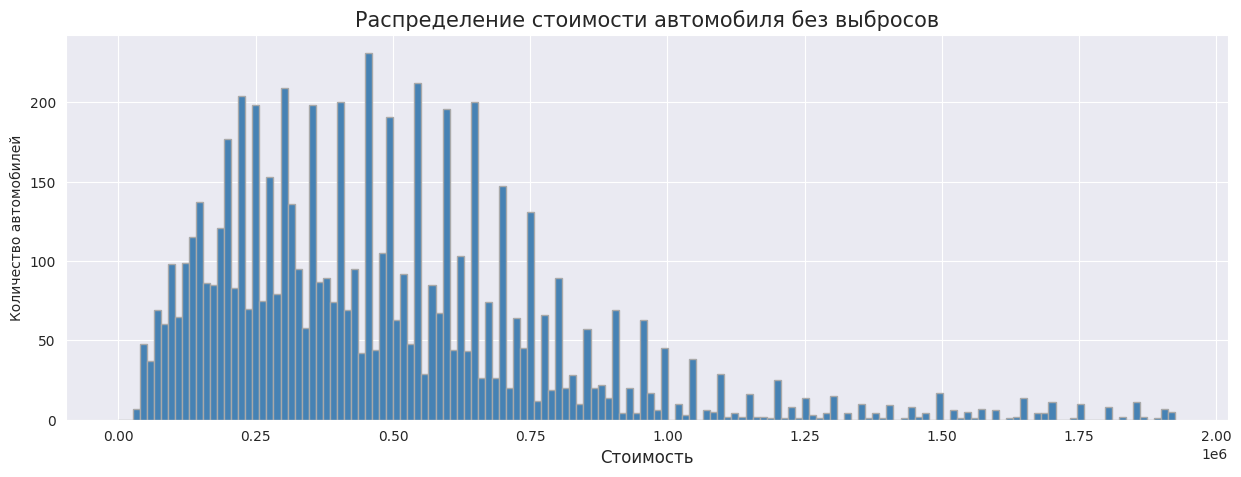

In [ ]:
df['selling_price'].hist(bins=150, range=(0, df['selling_price'].quantile(0.95)), color='steelblue',figsize=(15, 5), ec="darkgrey")
plt.title('Распределение стоимости автомобиля без выбросов', fontsize=15)
plt.xlabel('Стоимость', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=10)
plt.show()

На графике видно много свечей, пользователи указывают одинаковые цены  
Построим матрицу корреляций

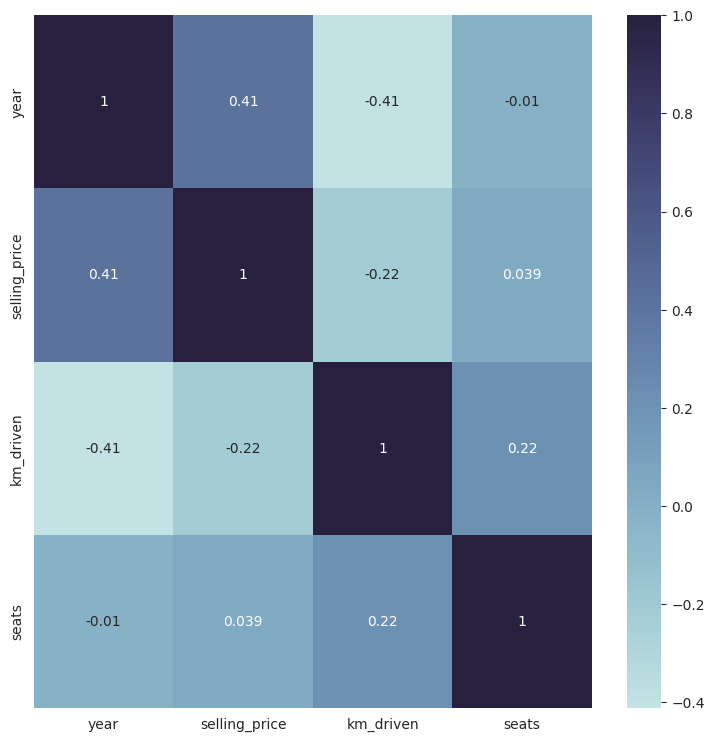

In [ ]:
fig = plt.figure(figsize=(9,9))

sns.heatmap(df.corr(numeric_only = True), annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

**Вывод:** У нас есть датафрейм 6999 строк, 13 столбцов, в пяти столбцах есть пропуски, целевая переменная имеет большой разброс.

## Предобработка данных

In [ ]:
df.head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0


In [ ]:
df[df['mileage'].isna()].iloc[:5]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
12,Maruti Swift 1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
28,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
69,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
78,Maruti Swift VDI BSIV W ABS,2015,475000,78000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN,NaN
107,Maruti Swift VDI BSIV,2010,300000,120000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN


Можем заметить, что количество пропусков совпадает в `mileage`, `engine`, `seats` в `torque` + 1, давайте проверим в разных строчках пропуски или нет.

In [ ]:
df_isna = df[(df['mileage'].isna() == True)
   & (df['engine'].isna() == True)
       & (df['seats'].isna() == True)]
df_isna.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          202
engine           202
max_power        196
torque           202
seats            202
dtype: int64

Так и есть 202 пропуска в одних строках, посмотрим что за дополнительный пропуск в `torque`

In [ ]:
df[(df['engine'].isna() == False)
       & (df['torque'].isna() == True)]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
4217,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0


Посмотрим на похожие автомобили

In [ ]:
df[(df['engine'] == '796 CC') & (df['fuel'] == 'CNG')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
31,Maruti Alto 800 CNG LXI Optional,2019,330000,10000,CNG,Individual,Manual,Second Owner,33.44 km/kg,796 CC,40.3 bhp,60Nm@ 3500rpm,4.0
751,Maruti Alto 800 CNG LXI,2012,165000,60000,CNG,Individual,Manual,Second Owner,30.46 km/kg,796 CC,47.3 bhp,69Nm@ 3500rpm,5.0
3348,Maruti Alto 800 CNG LXI,2017,260000,67000,CNG,Individual,Manual,First Owner,33.44 km/kg,796 CC,40.3 bhp,60Nm@ 3500rpm,4.0
3432,Maruti Alto 800 CNG LXI,2013,178000,70000,CNG,Individual,Manual,Second Owner,30.46 km/kg,796 CC,47.3 bhp,69Nm@ 3500rpm,5.0
4217,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9 km/kg,796 CC,bhp,NaN,8.0
4977,Maruti Alto 800 LXI CNG,2020,370000,16000,CNG,Individual,Manual,First Owner,33.0 km/kg,796 CC,47.3 bhp,69Nm@ 3500rpm,5.0
6285,Maruti Alto Green LXi (CNG),2012,150000,82300,CNG,Individual,Manual,Second Owner,26.83 km/kg,796 CC,38.4 bhp,62Nm@ 3000rpm,5.0
6293,Maruti Alto Green LXi (CNG),2010,155000,70000,CNG,Individual,Manual,Second Owner,26.83 km/kg,796 CC,38.4 bhp,62Nm@ 3000rpm,5.0
6499,Maruti Alto 800 CNG LXI Optional,2019,330000,10000,CNG,Individual,Manual,Second Owner,33.44 km/kg,796 CC,40.3 bhp,60Nm@ 3500rpm,4.0


Из за того что у нас нет значения `max_power` мы не можем корректно заполнить ячейку `torque`.  
Удалять ни чего не будем, попробуем заполнить значениями и посмотрим на результаты модели. Начнем с пробега, оставим только значение, пропуски заполним медианной по году выпуска.

In [ ]:
df['mileage'] = df['mileage'].str.split(' ').str[0]

In [ ]:
 df['mileage'] = df.groupby('year')['mileage'].transform(lambda x: x.fillna(x.median()))

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
df[df['mileage'].isna()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
277,Mahindra Willys CJ 3B 4X4,1983,300000,10000,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
1556,Mahindra Jeep MM 540,1995,160000,90000,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN
4550,Maruti Omni LPG STD BSIV,1991,55000,120000,LPG,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['mileage'] = df['mileage'].astype('float')

Осталось три машинки, заполним 95 квантилем.

In [ ]:
df['mileage'] = df['mileage'].fillna(df['mileage'].quantile(0.95))

Рабочий объём двигателя, пиковая мощность двигателя, крутящий момент все эти показатели схожи, понимания чем безболезненно заполнить пропуски в данный момент нет. Приведем к числу и посмотри на корреляцию, возможно оставим только один столбец.

In [ ]:
df['engine'] = df['engine'].str.split(' ').str[0]

In [ ]:
df['max_power'] = df['max_power'].str.split(' ').str[0]

In [ ]:
df['engine'] =df['engine'].astype(float)
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

In [ ]:
df['engine'].corr(df['max_power'])

0.7010340983442349

Ожидаемо корреляция получилась высокой

In [ ]:
df['max_power'].describe()

count    6802.000000
mean       91.500023
std        35.821622
min         0.000000
25%        68.050000
50%        82.000000
75%       102.000000
max       400.000000
Name: max_power, dtype: float64

Посмотрим на пиковую мощность относительно типа двигателя и заполним средним или медианой

In [ ]:
df[df['fuel'] == 'Petrol']['max_power'].describe()

count    3024.000000
mean       80.366825
std        30.638526
min         0.000000
25%        67.000000
50%        81.800000
75%        86.800000
max       400.000000
Name: max_power, dtype: float64

In [ ]:
df[df['fuel'] == 'Diesel']['max_power'].describe()

count    3700.000000
mean      101.265418
std        37.031226
min         0.000000
25%        74.000000
50%        88.760000
75%       120.000000
max       282.000000
Name: max_power, dtype: float64

Заполним `max_power` медианной в зависимости от типа двигателя.

In [ ]:
 df['max_power'] = df.groupby('fuel')['max_power'].transform(lambda x: x.fillna(x.median()))

In [ ]:
 df['engine'] = df.groupby('fuel')['engine'].transform(lambda x: x.fillna(x.median()))

Количество мест заполним просто средним

In [ ]:
df['seats'] = df['seats'].fillna(df['seats'].median())

In [ ]:
cat = df

In [ ]:
df = df.drop('torque', axis = 1)

In [ ]:
cat['torque'] = cat['torque'].fillna('unknown')

Давайте из имени достанем название бренда и сделаем два столбца.

In [ ]:
#df[['brand', 'name']] = df['name'].str.split(pat = ' ', n = 1 , expand= True)

In [ ]:
#df.head(3)

Странно, но результаты стали хуже, попробовал оставить только бренд, стало еще хуже   
Оставим как есть

У нас добавились числовые признаки, посмотрим ещё раз на матрицу корреляций

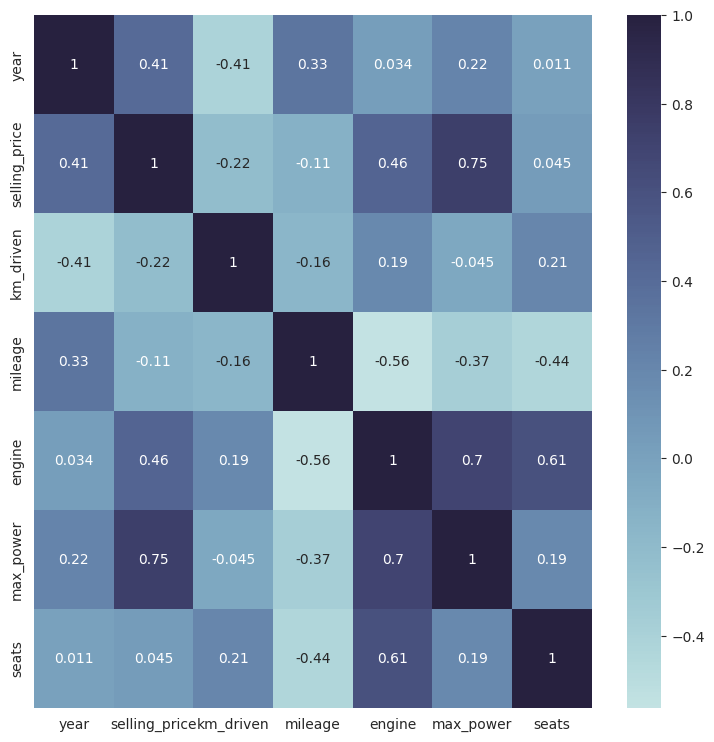

In [ ]:
fig = plt.figure(figsize=(9,9))

sns.heatmap(df.corr(numeric_only = True), annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

## Машинное обучение

### Линейна регрессия

Будем использовать Lasso

In [ ]:
df_get = pd.get_dummies(df)

In [ ]:
df_get.shape

(6999, 1945)

In [ ]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_get.drop(columns=['selling_price'])
y = df_get['selling_price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = RANDOM_STATE)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_st = scaler.fit_transform(X_train)  #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
print(X_train_st[:2])

[[ 0.78271289 -0.57687298  2.23625743 ... -0.5834687  -0.02315377
  -0.27211331]
 [-0.94167532 -0.74296526  0.08106553 ...  1.71388801 -0.02315377
  -0.27211331]]


In [ ]:
X_test_st = scaler.transform(X_test)

In [ ]:
model = Lasso()

In [ ]:
model.fit(X_train_st, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e+13, tolerance: 3.751e+11
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [ ]:
predictions = model.predict(X_test_st)

#### Изучим результаты

In [ ]:
# функция выводящая метрики
def error(y_test, predictions):
    print('MSE: {:.2f}'.format(mean_squared_error(y_test, predictions)))
    print('MAE: {:.2f}'.format(mean_absolute_error(y_test, predictions)))
    print('MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test, predictions)))

In [ ]:
error(y_test, predictions)

MSE: 31460091007.96
MAE: 89727.99
MAPE: 0.28


В среднем ошибаемся на 90000. Соберем результат в таблицу, посмотрим на каких машинах самая большая ошибка

In [ ]:
model.coef_, model.intercept_

(array([144857.15461894,  -9306.01368177,  38262.02411954, ...,
          -623.71055978,    833.06828901,    393.75820057]),
 647046.8647972893)

In [ ]:
comparison = pd.DataFrame({'y_test': y_test, 'predictions': predictions})

In [ ]:
comparison['predictions'] = comparison['predictions'].round(0)

In [ ]:
comparison['abs'] = np.abs(comparison['y_test'] - comparison['predictions'])

In [ ]:
comparison.sort_values(by = 'abs', ascending=False).iloc[:5]

,y_test,predictions,abs
1718,3200000,1138088.0,2061912.0
4834,3200000,1366016.0,1833984.0
1562,3200000,1366016.0,1833984.0
6307,2825000,1347203.0,1477797.0
1703,2825000,1347203.0,1477797.0


В ТОП 5 ошибок, модель  занизила стоимость машины, жадность людей погубила мою модель

In [ ]:
df[df['selling_price'] == 3200000].iloc[:3]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
119,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33,1999.0,177.0,5.0
326,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33,1999.0,177.0,5.0
359,Jaguar XF 2.0 Diesel Portfolio,2017,3200000,45000,Diesel,Dealer,Automatic,First Owner,19.33,1999.0,177.0,5.0


In [ ]:
comparison['abs'].describe().apply("{0:.2f}".format)

count       1400.00
mean       89728.00
std       153054.59
min            2.00
25%        17551.00
50%        46439.00
75%       101433.50
max      2061912.00
Name: abs, dtype: object

### CatBoost

In [ ]:
X = ['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']

cat_features = ['name', 'fuel','seller_type', 'transmission', 'owner', 'torque']

y = ['selling_price']

In [ ]:
train, test = train_test_split(cat, train_size=0.6, random_state = RANDOM_STATE)

In [ ]:
val, test = train_test_split(test,train_size=0.5, random_state = RANDOM_STATE)

In [ ]:
model_cat = CatBoostRegressor(cat_features=cat_features,
                              learning_rate = 0.75,
                              eval_metric = 'MAPE',
                              random_seed = RANDOM_STATE,
                              verbose=100)

In [ ]:
model_cat.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.7224869	test: 0.7303931	best: 0.7303931 (0)	total: 72.5ms	remaining: 1m 12s
100:	learn: 0.0181529	test: 0.0208655	best: 0.0208213 (95)	total: 4.15s	remaining: 36.9s
200:	learn: 0.0108589	test: 0.0150382	best: 0.0150382 (200)	total: 6.36s	remaining: 25.3s
300:	learn: 0.0081222	test: 0.0132972	best: 0.0132948 (290)	total: 7.78s	remaining: 18.1s
400:	learn: 0.0064207	test: 0.0127217	best: 0.0127217 (400)	total: 8.66s	remaining: 12.9s
500:	learn: 0.0053333	test: 0.0123473	best: 0.0123303 (487)	total: 9.52s	remaining: 9.48s
600:	learn: 0.0046011	test: 0.0123736	best: 0.0123146 (518)	total: 10.4s	remaining: 6.89s
700:	learn: 0.0039775	test: 0.0123716	best: 0.0123146 (518)	total: 11.2s	remaining: 4.79s
800:	learn: 0.0035024	test: 0.0123415	best: 0.0123146 (518)	total: 12.1s	remaining: 3s
900:	learn: 0.0030580	test: 0.0122366	best: 0.0122193 (892)	total: 13s	remaining: 1.42s
999:	learn: 0.0027315	test: 0.0121613	best: 0.0121359 (991)	total: 13.8s	remaining: 0us

bestTest = 0.012135

In [ ]:
test['pred'] = model_cat.predict(test[X])

Посмотрим на результаты

In [ ]:
error(test[y], test['pred'])

MSE: 1719288672.30
MAE: 8657.36
MAPE: 0.01


In [ ]:
test['abs'] = np.abs(test['selling_price'] - test['pred']).round(2)

In [ ]:
test['pred'] = test['pred'].round(0)

In [ ]:
test[['selling_price', 'pred', 'abs']].sort_values(by = 'abs', ascending=False).iloc[:5]

,selling_price,pred,abs
3113,1650000,665276.0,984723.79
4230,6223000,6759803.0,536802.83
6544,5830000,6257601.0,427600.78
5777,1850000,2211921.0,361921.28
124,5800000,6065799.0,265798.99


In [ ]:
test['abs'].describe().apply("{0:.2f}".format)

count      1400.00
mean       8657.36
std       40564.94
min           0.85
25%         772.55
50%        1843.03
75%        4186.98
max      984723.79
Name: abs, dtype: object

**Вывод:** CatBoost справился с задачей, считаю что модель получилась хорошей.

In [ ]:
# import pickle

# with open('model.pickle', 'wb') as f:
#     pickle.dump(model_cat, f)

#а так модель можно загрузить из файла:
# with open('model.pickle', 'rb') as f:
#     model_cat = pickle.load(f)

In [ ]:
#а так модель можно загрузить из файла:
# with open('model.pickle', 'rb') as f:
#      model_cat = pickle.load(f)

## Сделаем простенькую модель для сервиса Streamlit

Извлечем название бренда автомобиля

In [ ]:
cat[['brand', 'name']] = cat['name'].str.split(pat = ' ', n = 1 , expand= True)

In [ ]:
cat.head(2)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
0,Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0,Maruti
1,Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,Skoda


In [ ]:
cat['brand'].unique()

array(['Maruti', 'Skoda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Honda', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Isuzu', 'Peugeot'], dtype=object)

In [ ]:
cat['brand'].nunique()

30

Получили 30 брендов.  
Приступим у обучению

In [ ]:
X = ['brand', 'year', 'km_driven', 'fuel', 'transmission', 'owner', 'seats']
cat_features = ['brand', 'transmission', 'owner', 'fuel']
y = ['selling_price']

In [ ]:
train, test = train_test_split(cat, train_size=0.6, random_state = RANDOM_STATE)

In [ ]:
val, test = train_test_split(test,train_size=0.5, random_state = RANDOM_STATE)

In [ ]:
model_streamlit = CatBoostRegressor(cat_features=cat_features,
                              learning_rate = 0.07,
                              eval_metric = 'MAPE',
                              random_seed = RANDOM_STATE,
                              verbose=100)

In [ ]:
model_streamlit.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 1.2256653	test: 1.2384117	best: 1.2384117 (0)	total: 9.43ms	remaining: 9.42s
100:	learn: 0.2761013	test: 0.2685962	best: 0.2685962 (100)	total: 975ms	remaining: 8.68s
200:	learn: 0.2510298	test: 0.2495915	best: 0.2494905 (199)	total: 2.01s	remaining: 8s
300:	learn: 0.2394322	test: 0.2415828	best: 0.2415828 (300)	total: 2.82s	remaining: 6.56s
400:	learn: 0.2302659	test: 0.2363536	best: 0.2363503 (399)	total: 3.25s	remaining: 4.86s
500:	learn: 0.2249488	test: 0.2342120	best: 0.2341726 (494)	total: 3.68s	remaining: 3.67s
600:	learn: 0.2206131	test: 0.2324849	best: 0.2324178 (599)	total: 4.13s	remaining: 2.74s
700:	learn: 0.2167542	test: 0.2320225	best: 0.2319737 (698)	total: 4.56s	remaining: 1.95s
800:	learn: 0.2128304	test: 0.2304816	best: 0.2303710 (797)	total: 5s	remaining: 1.24s
900:	learn: 0.2095368	test: 0.2296594	best: 0.2294320 (888)	total: 5.42s	remaining: 595ms
999:	learn: 0.2061567	test: 0.2294323	best: 0.2292199 (989)	total: 5.86s	remaining: 0us

bestTest = 0.2292199

In [ ]:
test['pred_streamlit'] = model_streamlit.predict(test[X])

In [ ]:
test[X]

,brand,year,km_driven,fuel,transmission,owner,seats
5253,Hyundai,2009,110000,Petrol,Manual,First Owner,5.0
4560,Mahindra,2014,122000,Diesel,Manual,Second Owner,7.0
6731,Chevrolet,2009,30000,Petrol,Manual,First Owner,5.0
51,Audi,2013,33900,Diesel,Automatic,Second Owner,5.0
1322,Toyota,2018,49000,Diesel,Automatic,First Owner,7.0
...,...,...,...,...,...,...,...
3003,Hyundai,2007,2360457,Petrol,Manual,Second Owner,5.0
1768,Mahindra,2015,120000,Diesel,Manual,First Owner,9.0
3593,Honda,2017,28000,Petrol,Manual,First Owner,5.0
3826,Maruti,2016,64000,Petrol,Manual,First Owner,5.0


In [ ]:
error(test[y], test['pred_streamlit'])

MSE: 38413082415.23
MAE: 111048.89
MAPE: 0.24


Проверим как работает модель на новых данных

In [ ]:
prob = pd.DataFrame({'brand':['Toyota'], 'year':[2008], 'km_driven':[14370], 'fuel':['Diesel'], 'transmission':['Automatic'], 'owner':['First Owner'],'seats':[5.5]})
prob

,brand,year,km_driven,fuel,transmission,owner,seats
0,Toyota,2008,14370,Diesel,Automatic,First Owner,5.5


In [ ]:
rt = model_streamlit.predict(prob)
rt

array([689027.3756336])

In [ ]:
import pickle

with open('model_streamlit.pickle', 'wb') as f:
    pickle.dump(model_streamlit, f)

#а так модель можно загрузить из файла:
# with open('model.pickle', 'rb') as f:
#     model_cat = pickle.load(f)